# Chem 277B - Fall 2024 - Homework 5
## ANN - Artificial Neural Networks
*Submit this notebook to bCourses to receive a credit for this assignment.*
<br>
due: **Oct 29th 2024** 
<br>
**Please upload both, the .ipynb file and the corresponding .pdf**<br>
<br>

## 60 Points Total

The goal of this homework assignment is to understand how the complexity of the dataset and the design of the ANN (number of neurons and number of layers) with different parameters i.e. like learning rate and activation functions influence the performance of the ANN.<br>
**Important: Only use numpy for creating the ANN, pandas for data frames if neccessary and matplotlib/ seaborn for plotting, but no further external python libraries.**

**1) Create an artificial dataset, one for regression and one for classification each** <br>
Start with a data set similar to the molecule data set we have been using earlier with a moderate number of features (say five) and about 1000 data points.<br> 
Normalize the features between 0 and 1 for better convergence and split the dataset into **training and testing set**.

**2) Network Design**<br>
Use at least two hidden layers and experiment with different layer sizes. Use different activation functions, such like *Sigmoid*, *ReLU* or any other activation function of your choice.<br>
Implement dropout between the hidden layers (e.g., randomly drop 20-30% neurons).<br>
Add an output layer according to the optimization problem (regression vs classification).

**3) Training and Optimization**<br>
For regression, use Mean Squared Error (MSE) as the loss function. For classification, use cross entropy as loss function (you can use the codes provided in the lecture). Implement backpropagation manually for weight updates and use gradient descent for optimization. Now, train the network over multiple epochs and track the loss and accuracy.

**4) Evaluation**<br>
Monitor the loss and the accuracy for the different epochs. For classification, generate a confusion chart and plot a histogramm of the different probabilities (see the lecture) at the end of the training process.<br>
Evaluate the performance of the ANN with the test set in the same way.<br>
<br>
Now, experiment with different<br>
- training to test set ratios<br>
- different numbers of features in the data (say, $N_{feature} = 3, 5, 20, 50$)
- features that correlate
- different numbers of data points (say, $N_{sample} = 200, 2\,000, 5\,000, 10\,000$)

How does the accuracy change?

**5) Submission Requirements**<br>
Include a short report (1-2 pages) explaining:<br>
- your architecture choices (layers, neurons, activation functions, etc.)<br>
- how dropout was implemented.<br>
- training performance (loss and accuracy plots).<br>
- results and key insights.<br>

## Create artificial dataset function

**1) Create an artificial dataset, one for regression and one for classification each** <br>
Start with a data set similar to the molecule data set we have been using earlier with a moderate number of features (say five) and about 1000 data points.<br> 
Normalize the features between 0 and 1 for better convergence and split the dataset into **training and testing set**.

In [158]:
import numpy as np
import pandas as pd
import random 
from sklearn.preprocessing import MinMaxScaler  #to normalize data
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [ ]:

def create_dataset(num_data_points, num_features):

    df = pd.DataFrame()

    for num in range(num_features):
        curr_column = np.random.randint(0, 100, size = num_data_points)
        normalized_curr_col = MinMaxScaler().fit_transform(curr_column.reshape(-1,1)).flatten()
        df[f"feature {num+1}"] = normalized_curr_col.flatten()

    return df


## make classification function

In [115]:
#make it a classification dataframe

def make_class_df(df):
    copy_df = df.copy()

    columns = df.shape[1]

    columns_list = np.arange(1, columns+1)

    random_col = np.random.choice(columns_list, 2, replace = False)

    toxic = (df[f"feature {random_col[0]}"] + df[f"feature {random_col[1]}"] > 1).astype(int)

    copy_df['toxic'] = toxic

    return copy_df



## make Train test split function for regression

In [116]:
from sklearn.model_selection import train_test_split

def tt_split_regression(df, test_percent):

    #make last feature Y

    Y = df.iloc[:,-1]

    X = df.iloc[:,:-1]

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_percent )

    return x_train, x_test, y_train, y_test

## Train test split function for classification df

In [117]:
def tt_split_classification(df, test_percent):

    #make last feature Y

    Y = df['toxic']

    X = df.drop(columns = "toxic")

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_percent )

    return x_train, x_test, y_train, y_test

## Create regression and classification dataframes and do train test split

In [118]:
 ## create regression dataframe
rg_df_1 = create_dataset(1000, 5)

#create classificaiton dataframe
cl_df_1 = make_class_df(rg_df_1)
#display(cl_df_1)
#print(cl_df_1['toxic'])

#train test split regression dataframe
x_train_reg, x_test_reg, y_train_reg, y_test_reg = tt_split_regression(rg_df_1, 0.3)

#train test split classification dataframe
x_train_cla, x_test_cla, y_train_cla, y_test_cla = tt_split_regression(cl_df_1, 0.3)



## Using classes from ANNIII.ipynb

In [179]:
class Layer_Dense():
    
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.1* np.random.randn(n_inputs, n_neurons)
        self.biases  = np.zeros((1, n_neurons))
        
    def forward(self, inputs):
        self.output  = np.dot(inputs, self.weights) + self.biases
        self.inputs  = inputs

    def backward(self, dvalues):
        #gradients
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases  = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs  = np.dot(dvalues, self.weights.T)

class Activation_ReLU():
    
    def forward(self, inputs):
        self.output  = np.maximum(0, inputs)
        self.inputs  = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0#ReLU derivative

class Activation_Sigmoid():
        
    def forward(self, inputs):
        self.output = np.clip(1/(1 + np.exp(-inputs)), 1e-7, 1-1e-7)
        self.inputs = inputs

    def backward(self, dvalues):
        sigm         = self.output
        deriv        = np.multiply(sigm, (1 - sigm))#inner derivative of sigmoid
        self.dinputs = np.multiply(deriv, dvalues)

class Activation_Softmax:
  
    def forward(self,inputs):
        self.inputs = inputs
        exp_values  = np.exp(inputs - np.max(inputs, axis = 1,\
                                      keepdims = True))#max in order to 
                                                       #prevent overflow
        #normalizing probs (Boltzmann dist.)
        probabilities = exp_values/np.sum(exp_values, axis = 1,\
                                      keepdims = True)  
        self.output   = probabilities                                                
    
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for i, (single_output, single_dvalues) in \
            enumerate(zip(self.output, dvalues)):
            
            single_output   = single_output.reshape(-1,1)
            jacobMatr       = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            self.dinputs[i] = np.dot(jacobMatr, single_dvalues)


class Loss:
     
     def calculate(self, output, y):
         
         sample_losses = self.forward(output, y)
         data_loss     = np.mean(sample_losses)
         return(data_loss)
    
    
class Loss_CategoricalCrossEntropy(Loss): 

     def forward(self, y_pred, y_true):
         samples = len(y_pred)
         #removing vals close to zero and one bco log and accuracy
         y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
         
         #now, depending on how classes are coded, we need to get the probs
         if len(y_true.shape) == 1:#classes are encoded as [[1],[2],[2],[4]]
             correct_confidences = y_pred_clipped[range(samples), y_true]
         elif len(y_true.shape) == 2:#classes are encoded as
                                    #[[1,0,0], [0,1,0], [0,1,0]]
             correct_confidences = np.sum(y_pred_clipped*y_true, axis = 1)
         #now: calculating actual losses
         negative_log_likelihoods = -np.log(correct_confidences)
         return(negative_log_likelihoods)
         
     def backward(self, dvalues, y_true):
         Nsamples = len(dvalues)
         Nlabels  = len(dvalues[0])
         #turning labels into one-hot i. e. [[1,0,0], [0,1,0], [0,1,0]], if
         #they are not
         if len(y_true.shape) == 1:
            y_true = np.eye(Nlabels)[y_true]
         #normalized gradient
         self.dinputs = -y_true/dvalues/Nsamples



#Creating a class as parent for softmax, loss and entropy classes. 
#Actually not neccessary, but saves code when building the ANN
class Activation_Softmax_Loss_CategoricalCrossentropy():
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss       = Loss_CategoricalCrossEntropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output#the probabilities
        #calculates and returns mean loss
        return(self.loss.calculate(self.output, y_true))
        
    def backward(self, dvalues, y_true):
        Nsamples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis = 1)
        self.dinputs = dvalues.copy()
        #calculating normalized gradient
        self.dinputs[range(Nsamples), y_true] -= 1
        self.dinputs = self.dinputs/Nsamples

class Optimizer_SGD:
    #initializing with a default learning rate of 0.01
    def __init__(self, learning_rate = 0.01, decay = 0, momentum = 0):
        self.learning_rate         = learning_rate
        self.current_learning_rate = learning_rate
        self.decay                 = decay
        self.iterations            = 0
        self.momentum              = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1/ (1 + self.decay*self.iterations))
        
    def update_params(self, layer):
        
        #if we use momentum
        if self.momentum:
            
            #check if layer has attribute "momentum"
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums   = np.zeros_like(layer.biases)
                
            #now the momentum parts
            weight_updates = self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates   = -self.current_learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases  += bias_updates
        
    def post_update_params(self):
        self.iterations += 1


class Layer_dropout():
    #source : https://www.youtube.com/watch?v=tkvlspCbLqo&ab_channel=Vizuara

    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs):
        self.inputs = inputs
        #generate scaled binary mask
        self.binary_mask = np.random.binomial(1, self.rate, size = inputs.shape) / self.rate
        #apply mask to output values
        self.output = inputs * self.binary_mask

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask


        

## Network Design

Use at least two hidden layers and experiment with different layer sizes. Use different activation functions, such like *Sigmoid*, *ReLU* or any other activation function of your choice.<br>
Implement dropout between the hidden layers (e.g., randomly drop 20-30% neurons).<br>
Add an output layer according to the optimization problem (regression vs classification).

## Regression ANN

In [181]:
# set up parameters

Nneurons1 = 64
Nneurons2 = 128
Nneurons3 = 256

Nepochs = 2000
learning_rate = 0.00001
decay = 0.001
momentum = 0.8
dropout_rate = 0.2

Nfeatures = x_train_reg.shape[1] #columns in regression df
display(x_train_reg)
print(x_train_reg.shape[1])

dense1 = Layer_Dense(Nfeatures, Nneurons1)
dense2 = Layer_Dense(Nneurons1, Nneurons2)
dense3 = Layer_Dense(Nneurons2, 1)

drop1 = Layer_dropout(dropout_rate)
drop2 = Layer_dropout(dropout_rate)
drop3 = Layer_dropout(dropout_rate)


optimizer = Optimizer_SGD(learning_rate = learning_rate, decay = decay, momentum = momentum)

ReLU1 = Activation_ReLU()
ReLU2 = Activation_ReLU()
ReLU3 = Activation_ReLU()

loss_activation =  mean_squared_error

Target = y_train_reg


,feature 1,feature 2,feature 3,feature 4
863,0.252525,0.696970,0.353535,0.232323
134,0.434343,0.646465,0.313131,0.575758
773,0.787879,0.151515,0.515152,0.040404
479,0.424242,0.111111,0.303030,0.616162
853,0.646465,0.262626,0.282828,0.444444
...,...,...,...,...
856,0.151515,0.313131,0.757576,0.434343
925,0.585859,0.666667,0.202020,0.666667
593,0.212121,0.545455,0.909091,0.222222
127,0.535354,0.030303,0.878788,0.787879


4


In [182]:
Monitor = np.zeros((Nepochs, 3)) #stores loss, learning rate, accuracy

for epoch in range(Nepochs):

    '''
    FORWARD PASS
    --------------
    '''

    #layer 1 forward
    dense1.forward(x_train_reg)
    ReLU1.forward(dense1.output)
    drop1.forward(ReLU1.output)

    #layer 2 forward 
    dense2.forward(drop1.output)
    ReLU2.forward(dense2.output)
    drop2.forward(ReLU2.output)

    #layer 3 forward
    dense3.forward(drop2.output)
    

    #get predictions
    Y_pred = dense3.output

    #display(Y_pred)
    #print("Y-pred: ",Y_pred.shape)
    #print("y_train_reg: ", Target.shape)
    
    #reshape to 1D
    oned_Y_pred = np.reshape(Y_pred, -1)
    oned_Target = np.reshape(Target, -1)

    loss = loss_activation(oned_Target, oned_Y_pred) #MSE

    RMSE = math.sqrt(loss)

    #calculate gradient of MSE (2/n(Y_pred - Target))
    dY_pred = 2 * ( oned_Y_pred - oned_Target) / Target.shape[0]

    #fix dY_pred dimensions
    dY_pred = dY_pred.reshape(Y_pred.shape)
    '''
    BACKWARD PASS
    -----------------
    '''
    #layer 3 backward
    dense3.backward(dY_pred)

    #layer 2 backward
    drop2.backward(dense3.dinputs)
    ReLU2.backward(drop2.dinputs)
    dense2.backward(ReLU2.dinputs)

    #layer 1 backward
    drop1.backward(dense2.dinputs)
    ReLU1.backward(drop1.dinputs)
    dense1.backward(ReLU1.dinputs)

    '''
    Apply gradient descent

    this only applies to layers with weights, therefore exclude activation layers
    (ReLU1,2,3 and drop1,2, and 3)
    '''
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

    Monitor[epoch, 0] = RMSE #accuracy
    Monitor[epoch, 1] = loss #MSE
    Monitor[epoch,  2] = optimizer.current_learning_rate
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'accuracy (RMSE): {RMSE:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'actual learning rate: {optimizer.current_learning_rate}')  


epoch: 0, accuracy (RMSE): 0.594, loss: 0.353, actual learning rate: 1e-05
epoch: 100, accuracy (RMSE): 0.579, loss: 0.335, actual learning rate: 9.090909090909091e-06
epoch: 200, accuracy (RMSE): 0.570, loss: 0.325, actual learning rate: 8.333333333333334e-06
epoch: 300, accuracy (RMSE): 0.564, loss: 0.318, actual learning rate: 7.692307692307692e-06
epoch: 400, accuracy (RMSE): 0.554, loss: 0.307, actual learning rate: 7.1428571428571436e-06
epoch: 500, accuracy (RMSE): 0.554, loss: 0.307, actual learning rate: 6.666666666666667e-06
epoch: 600, accuracy (RMSE): 0.546, loss: 0.298, actual learning rate: 6.25e-06
epoch: 700, accuracy (RMSE): 0.540, loss: 0.292, actual learning rate: 5.88235294117647e-06
epoch: 800, accuracy (RMSE): 0.536, loss: 0.287, actual learning rate: 5.555555555555557e-06
epoch: 900, accuracy (RMSE): 0.530, loss: 0.281, actual learning rate: 5.263157894736842e-06
epoch: 1000, accuracy (RMSE): 0.527, loss: 0.278, actual learning rate: 5e-06
epoch: 1100, accuracy (

Evaluating the fit of the regression ANN model

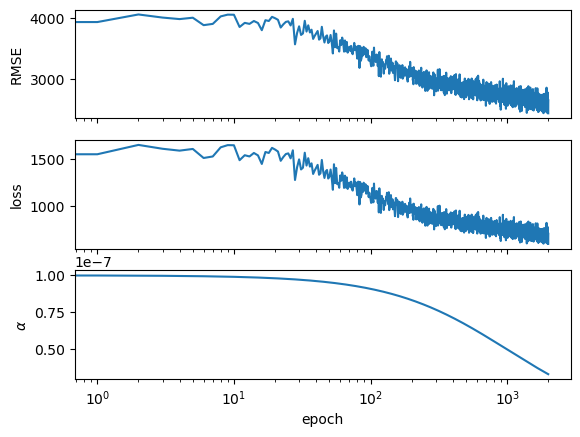

In [176]:
xplot = np.arange(Nepochs)

fig1, ax1 = plt.subplots(3, 1, sharex = True)
ax1[0].plot(xplot, 100*Monitor[:,0])
ax1[0].set_ylabel('RMSE')
ax1[1].plot(xplot, Monitor[:,1])
ax1[1].set_ylabel('loss')
ax1[2].plot(xplot, Monitor[:,2])
ax1[2].set_ylabel(r'$\alpha$')
ax1[2].set_xlabel('epoch')
plt.xscale('log', base = 10)
plt.show()

## Classification ANN

set up parameters

In [ ]:
# set up parameters

Nneurons1 = 64
Nneurons2 = 128
Nneurons3 = 256

Nepochs = 2000
learning_rate = 0.001
decay = 0.001
momentum = 0.8
dropout_rate = 0.2

Nfeatures = x_train_cla.shape[1] #columns in regression df

dense1 = Layer_Dense(Nfeatures, Nneurons1)
dense2 = Layer_Dense(Nneurons1, Nneurons2)
dense3 = Layer_Dense(Nneurons2, Nfeatures)

drop1 = Layer_dropout(dropout_rate)
drop2 = Layer_dropout(dropout_rate)
drop3 = Layer_dropout(dropout_rate)


optimizer = Optimizer_SGD(learning_rate = learning_rate, decay = decay, momentum = momentum)

sigmoid1 = Activation_Sigmoid()
sigmoid2 = Activation_Sigmoid()
sigmoid3 = Activation_Sigmoid()

loss_activation =  Activation_Softmax_Loss_CategoricalCrossentropy

Target = y_train_cla


## Training Classification ANN

In [ ]:
Monitor_cla = np.zeros((Nepochs, 3))

for epoch in range(Nepochs):
    #layer 1 forward pass class ANN
    dense1.forward(x_train_cla)
    sigmoid1.forward(dense1.output)
    drop1.forward(sigmoid1.output)

    #layer 2 forward pass class ANN
    dense2.forward(drop1.output)
    sigmoid2.forward(dense2.output)
    drop2.forward(sigmoid2.output)

    


